In [38]:
import eli5
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from joblib import dump
from pandas import np
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report, flat_accuracy_score

from crf_extraction.first_crf_model.first_model_features import sent_to_features, sent_to_labels
from utils.DrugRecords import DrugRecords
from utils.helper_functions import generate_heatmap_percentage, generate_heatmap_values
from utils.helper_functions import get_data

/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [39]:
TRAINING_DATASET_PATH = "../../datasets/train_dataset.csv"
VALIDATION_DATASET_PATH = "../../datasets/validation_dataset.csv"
TEST_DATASET_PATH = "../../datasets/test_dataset.csv"
JOBLIB_MODEL = 'trained.joblib'
JOBLIB_TUNED_MODEL = 'trained_tuned.joblib'

In [40]:
training_data = get_data(TRAINING_DATASET_PATH)
training_data.head(10)

,Drug: #,Word,Tag
0,Drug: #,Word,Tag
1,Drug: 0,ventamol,NAME
2,Drug: 0,2,STRENGTH
3,Drug: 0,mg,STRENGTH
4,Drug: 0,/,STRENGTH
5,Drug: 0,5,STRENGTH
6,Drug: 0,ml,STRENGTH
7,Drug: 0,syrup,FORM
8,Drug: 0,120,PACK
9,Drug: 0,ml,PACK


In [41]:
train_drug_records = DrugRecords(training_data).get_drug_records()
train_drug_records = train_drug_records[1:] # without header

In [42]:
x_train = [sent_to_features(s) for s in train_drug_records]
y_train = [sent_to_labels(s) for s in train_drug_records]

In [43]:
x_train[0][0] # features for word "ventamol"

{'bias': 1.0,
 'word[-2:]': 'ol',
 'word[:-3]': 'venta',
 'word.isdigit()': False,
 'BOS': True,
 '+1:bias': 1.0,
 '+1:word[-2:]': '2',
 '+1:word[:-3]': '',
 '+1:word.isdigit()': True}

Fit and save the model

In [44]:
crf = CRF(c1=0, c2=1, max_iterations=1, all_possible_transitions=False)
crf.get_params()

{'algorithm': None,
 'all_possible_states': None,
 'all_possible_transitions': False,
 'averaging': None,
 'c': None,
 'c1': 0,
 'c2': 1,
 'calibration_candidates': None,
 'calibration_eta': None,
 'calibration_max_trials': None,
 'calibration_rate': None,
 'calibration_samples': None,
 'delta': None,
 'epsilon': None,
 'error_sensitive': None,
 'gamma': None,
 'keep_tempfiles': None,
 'linesearch': None,
 'max_iterations': 1,
 'max_linesearch': None,
 'min_freq': None,
 'model_filename': None,
 'num_memories': None,
 'pa_type': None,
 'period': None,
 'trainer_cls': None,
 'variance': None,
 'verbose': False}

In [45]:
%%time

crf.fit(x_train, y_train)
dump(crf, JOBLIB_MODEL)

CPU times: user 12.4 s, sys: 115 ms, total: 12.5 s
Wall time: 12.5 s


['trained.joblib']

In [46]:
x_train = [sent_to_features(s) for s in train_drug_records]
y_train = [sent_to_labels(s) for s in train_drug_records]

In [47]:
y_pred = cross_val_predict(estimator=crf, X=x_train, y=y_train, cv=5)

In [48]:
class_report = flat_classification_report(y_pred=y_pred, y_true=y_train, digits=4)
print(class_report)

/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        FORM     0.0000    0.0000    0.0000    315394
        NAME     0.0000    0.0000    0.0000    200615
           O     0.0000    0.0000    0.0000     84099
        PACK     0.0000    0.0000    0.0000    309008
    STRENGTH     0.3270    1.0000    0.4928    441687

    accuracy                         0.3270   1350803
   macro avg     0.0654    0.2000    0.0986   1350803
weighted avg     0.1069    0.3270    0.1611   1350803



In [49]:
eli5.show_weights(crf, top=20)

Evaluate on validation data

In [50]:
validation_data = get_data(VALIDATION_DATASET_PATH)

validation_drug_records = DrugRecords(validation_data).get_drug_records()
validation_drug_records = validation_drug_records[1:]

In [51]:
x_val = [sent_to_features(s) for s in validation_drug_records]
y_val = [sent_to_labels(s) for s in validation_drug_records]

In [52]:
predicted_values = crf.predict(x_val)

In [53]:
acc_score = flat_accuracy_score(predicted_values, y_val)
print(acc_score)

0.32577679797013437


Evaluate on test data

In [54]:
test_data = get_data(TEST_DATASET_PATH)

test_drug_records = DrugRecords(test_data).get_drug_records()
test_drug_records = test_drug_records[1:]

In [55]:
x_test = [sent_to_features(s) for s in test_drug_records]
y_test = [sent_to_labels(s) for s in test_drug_records]

In [56]:
predicted_values_test = crf.predict(x_test)

In [57]:
acc_score = flat_accuracy_score(predicted_values_test, y_test)
print(acc_score)


0.32552038406396305


Cross matrix on test data

In [58]:
y_pred = pd.Series([p for pred_val in predicted_values_test for p in pred_val])
y_true_test = pd.Series([w[1] for drug_record in test_drug_records for w in drug_record])

matrixPercentage = pd.crosstab(y_true_test,
                               y_pred,
                               rownames=['True'], colnames=['Predicted'], normalize="index").round(6)*100

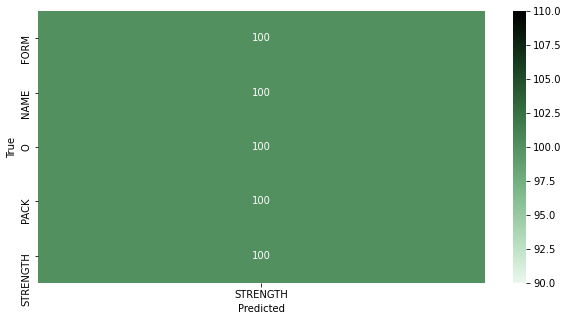

In [60]:
plt.figure(figsize=(10, 5))
sns_plot_percentage = generate_heatmap_percentage(matrixPercentage)

sns_plot_percentage.figure.savefig("firstCrfModelMatrix.png")

Hyper-parameter tuning

In [61]:
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'max_iterations': [int(x) for x in np.linspace(start=40, stop=150, num=10)],
    'all_possible_transitions': [True, False]
}

In [62]:
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted',
                        labels=['O', 'NAME', 'STRENGTH', 'PACK', 'FORM'])

In [63]:
rand_search_cv = RandomizedSearchCV(crf, params_space,
                        cv=4,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

In [64]:
rand_search_cv.fit(x_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Traceback (most recent call last):
  File "/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/joblib/parallel.py", line 921, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 540, in wrap_future_result
    return future.result(timeout=timeout)
  File "/usr/lib/python3.7/concurrent/futures/_base.py", line 430, in result
    self._condition.wait(timeout)
  File "/usr/lib/python3.7/threading.py", line 296, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipytho

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



TypeError: can only concatenate str (not "list") to str

In [ ]:
print('best params:', rand_search_cv.best_params_)
print('best CV score:', rand_search_cv.best_score_)
print('model size: {:0.2f}M'.format(rand_search_cv.best_estimator_.size_ / 1000000))

In [ ]:
tuned_crf = rand_search_cv.best_estimator_
dump(tuned_crf, JOBLIB_TUNED_MODEL)

Evaluate tuned model with cross-validation

In [ ]:
y_pred = cross_val_predict(estimator=tuned_crf, X=x_train, y=y_train, cv=5)

In [ ]:
class_report = flat_classification_report(y_pred=y_pred, y_true=y_train, digits=4)
print(class_report)

In [ ]:
eli5.show_weights(tuned_crf, top=20)

Evaluate tuned model on validation data

In [ ]:
predicted_values_val = tuned_crf.predict(x_val)

In [ ]:
acc_score = flat_accuracy_score(predicted_values_val, y_val)
print(acc_score)

Evaluate on test data

In [ ]:
predicted_values_test = tuned_crf.predict(x_test)

In [ ]:
acc_score = flat_accuracy_score(predicted_values_test, y_test)
print(acc_score)


Cross matrices on test data

In [ ]:
y_pred = pd.Series([p for pred_val in predicted_values_test for p in pred_val])

matrixPercentage = pd.crosstab(y_true_test,
                               y_pred,
                               rownames=['True'], colnames=['Predicted'], normalize="index").round(6)*100

In [ ]:
plt.figure(figsize=(10, 5))
sns_plot_percentage = generate_heatmap_percentage(matrixPercentage)

sns_plot_percentage.figure.savefig("firstTunedCrfModelMatrix.png")
